In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import seaborn as sns
import src.util as util
import src.topology as topology
import networkx as nx
from src.nova_join import Operator, OperatorType, NovaSolver
from src.util import log_opt_label, coordinator_label, worker_label, centroid_label, ch_label, join_label
from src.cardinalities import create_cardinalities, create_adjacency_matrix, create_unique_n_tuples, \
    create_adjacency_matrix_from_pairs, generate_random_integer_dict
from src.util import evaluate_graph, plot_distributions_pdf
from src.topology import create_topologies_from_dict
import os
from src.baselines import sink_based_placement, source_based_placement, top_c
from src.eval_tools import *

#### Topology Setup

In [2]:
seed = 10

worker_capacity = (1, 200)
source_capacity = (1, 50)
source_frac = 0.6
coord_cols = ["x", "y"]

X_dim = [-200, 1000]
Y_dim = [-200, 900]
centers = 10
clustering = False

eval_matrix = {}

In [3]:
# Specify the directory path
directory_path = 'datasets/atlas/02072023/coords/'

# Iterate over all files in the directory
coord_dict = {}
for filename in os.listdir(directory_path):
    # Check if it's a file (not a directory)
    file = os.path.join(directory_path, filename)
    if os.path.isfile(file):
        df = topology.coords_ripe_atlas(file, labels=False)
        # df["x"] = df["x"] - df["x"].mean()
        # df["y"] = df["y"] - df["y"].mean()

        df['latency'] = list(zip(df.x, df.y))
        df['latency'] = df['latency'].apply(lambda x: np.linalg.norm(x - df.loc[0, ["x", "y"]].to_numpy()))
        f = filename.replace(".csv", "")
        f = int(f.replace("time-", ""))
        coord_dict[f] = df

coord_list = []
coord_mean = coord_dict[0][["x", "y"]].copy()
for i in sorted(coord_dict.keys()):
    coord_list.append(coord_dict[i])
    if i > 0:
        coord_mean["x"] += coord_dict[i]["x"]
        coord_mean["y"] += coord_dict[i]["y"]
coord_mean["x"] = coord_mean["x"] / len(coord_dict)
coord_mean["y"] = coord_mean["y"] / len(coord_dict)
coord_mean['latency'] = list(zip(coord_mean.x, coord_mean.y))
coord_mean['latency'] = coord_mean['latency'].apply(
    lambda x: np.linalg.norm(x - coord_mean.loc[0, ["x", "y"]].to_numpy()))

t_label = 0
coords_df = coord_dict[t_label]
s_dict = {t_label: coord_mean}

In [4]:
device_number = coord_dict[t_label].shape[0]
prim_df, base_col, capacity_columns = \
create_topologies_from_dict(s_dict, coord_cols, worker_capacity=worker_capacity,
                            source_capacity=source_capacity, source_frac=source_frac, with_clustering=clustering,
                            seed=seed)[t_label]

eval_columns = ["capacity_1", "capacity_5"]
opt_k = prim_df["cluster"].nunique()
num_sources = prim_df[prim_df["type"] == "SOURCE"].shape[0]
num_workers = prim_df[prim_df["type"] == "WORKER"].shape[0]
num_sinks = prim_df[prim_df["type"] == "SINK"].shape[0]

print(f"n={prim_df.shape[0]}, sinks={num_sinks}, workers={num_workers}, sources={num_sources}")
prim_df.head(10)

Creating df for 0
Done
n=631, sinks=1, workers=252, sources=378


x           y     latency  cluster    type  capacity_inf  \
0  308.494393  272.860026    0.000000        0    SINK       9999999   
1  316.976824  275.994535    9.043051        0  SOURCE       9999999   
2  282.361038  258.647238   29.748203        0  SOURCE       9999999   
3  306.501880  265.083892    8.027351        0  SOURCE       9999999   
4  298.626985  272.848666    9.867415        0  SOURCE       9999999   
5  290.092099  262.323459   21.205275        0  SOURCE       9999999   
6  385.222035  687.879640  422.052616        0  SOURCE       9999999   
7    5.227394  201.997901  311.435890        0  SOURCE       9999999   
8  444.203377  407.520301  191.181375        0  SOURCE       9999999   
9  304.542842  271.014081    4.361453        0  SOURCE       9999999   

   capacity_0  capacity_1  capacity_2  capacity_3  capacity_4  capacity_5  
0         100         100         100         100         100         100  
1          38          25          18          12           6           1  
2           2          11          16          21          25          29  
3          32          26          23          21          18          16  
4          37          25          18          12           7           2  
5          25          25          24          24          24          24  
6          12          23          30          36          41          46  
7          10          18          23          27          30          34  
8          38          28          23          18          14          10  
9           9           6           5           4           3           2

Total: Step 0 -> Sum: 33373, Mean: 52.97, Median: 35.00, Min: 1.00, Max: 197.00
Total: Step 1 -> Sum: 33367, Mean: 52.96, Median: 33.00, Min: 2.00, Max: 247.00
Total: Step 2 -> Sum: 33362, Mean: 52.96, Median: 33.00, Min: 2.00, Max: 290.00
Total: Step 3 -> Sum: 33373, Mean: 52.97, Median: 33.00, Min: 1.00, Max: 369.00
Total: Step 4 -> Sum: 33367, Mean: 52.96, Median: 30.00, Min: 1.00, Max: 445.00
Total: Step 5 -> Sum: 33348, Mean: 52.93, Median: 27.00, Min: 0.00, Max: 515.00
WORKER: Step 0 -> Sum: 24114, Mean: 95.69, Median: 96.00, Min: 1.00, Max: 197.00
WORKER: Step 1 -> Sum: 24115, Mean: 95.69, Median: 96.50, Min: 10.00, Max: 247.00
WORKER: Step 2 -> Sum: 24115, Mean: 95.69, Median: 87.00, Min: 7.00, Max: 290.00
WORKER: Step 3 -> Sum: 24115, Mean: 95.69, Median: 80.00, Min: 5.00, Max: 369.00
WORKER: Step 4 -> Sum: 24124, Mean: 95.73, Median: 75.00, Min: 3.00, Max: 445.00
WORKER: Step 5 -> Sum: 24101, Mean: 95.64, Median: 72.00, Min: 1.00, Max: 515.00
SOURCE: Step 0 -> Sum: 9259, Mean

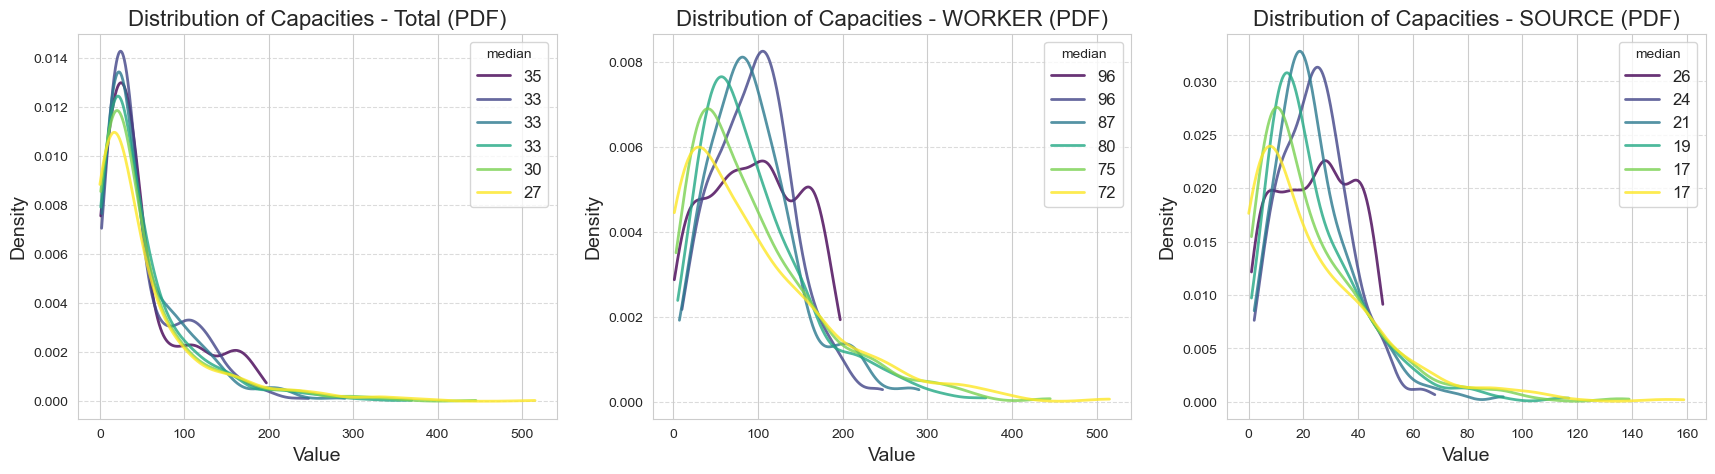

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(21, 5))

# Display the total distributions
distributions = []
medians = {}
total_mean = []
sum_capacities = 0
for i, col in enumerate(capacity_columns):
    dist = prim_df[prim_df["type"] != "SINK"][col].to_numpy()
    distributions.append(dist)
    medians[col] = np.median(dist)
    total_mean.append(np.mean(dist))
    sum_capacities += np.sum(dist)
    print(f"Total: Step {i} -> Sum: {np.sum(dist)}, Mean: {np.mean(dist):.2f}, Median: {np.median(dist):.2f}, Min: {np.min(dist):.2f}, Max: {np.max(dist):.2f}")
sum_capacities = sum_capacities // len(distributions)
# Plot the PDFs
dist_colors = plt.cm.viridis(np.linspace(0, 1, len(distributions)))
plot_distributions_pdf(axes[0], distributions, dist_colors)
axes[0].set_title('Distribution of Capacities - Total (PDF)', fontsize=16)

# Display the individual distributions
for cnt_idx, type in enumerate(["WORKER", "SOURCE"]):
    dist_type = []
    for i, col in enumerate(capacity_columns):
        dist = prim_df[prim_df["type"] == type][col].to_numpy()
        dist_type.append(dist)
        print(f"{type}: Step {i} -> Sum: {np.sum(dist)}, Mean: {np.mean(dist):.2f}, Median: {np.median(dist):.2f}, Min: {np.min(dist):.2f}, Max: {np.max(dist):.2f}")
    # Plot the PDFs
    dist_colors = plt.cm.viridis(np.linspace(0, 1, len(dist_type)))
    plot_distributions_pdf(axes[cnt_idx+1], dist_type, dist_colors)
    axes[cnt_idx+1].set_title(f'Distribution of Capacities - {type} (PDF)', fontsize=16)

total_mean = int(np.mean(total_mean))
print("Total Mean:", total_mean)

plt.savefig(f"plots/atlas/atlas_ct_{device_number}_capacity_dist.svg", bbox_inches="tight")
plt.show()

In [6]:
colors, colors_hex, light_colors = util.get_color_list(opt_k)
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)]

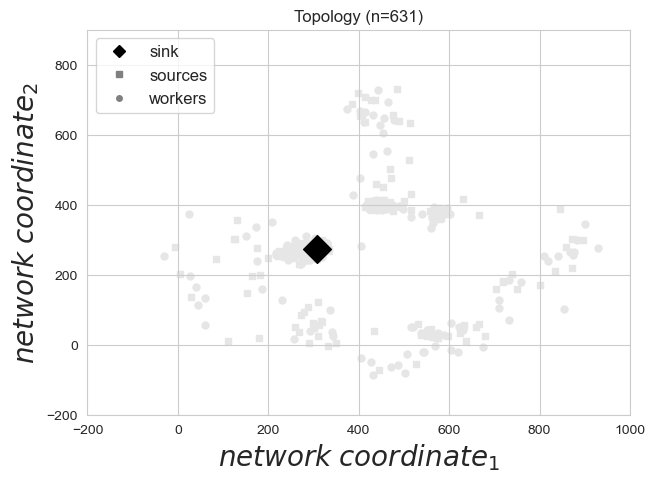

In [7]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
ax1 = util.plot_topology(ax1, prim_df, show_legend=True, show_coordinator=True)

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

plt.savefig(f"plots/atlas/atlas_ct_{device_number}_ncs.svg", bbox_inches="tight")

plt.title(f"Topology (n={device_number})")

plt.show()

### Create Join Matrix

In [8]:
# Create a list of labels for the index and columns
source_indices = list(prim_df[prim_df["type"] == "SOURCE"].index.values)
sink_capacity = len(source_indices) * 5
input_range = [1, 75]
output_range = [1, 200]
total_sum_sources = (np.mean(input_range) * num_sources)
prim_df.loc[prim_df[prim_df["type"] == "SINK"].index, capacity_columns] = sink_capacity + 0.4 * sink_capacity
print(f"Sources={len(source_indices)}, Sum capacities={sum_capacities}; Sum load sources={total_sum_sources}; Sum load output={sink_capacity}")

source_cardinalities = generate_random_integer_dict(source_indices, total_sum_sources, input_range[0], input_range[1],
                                                    seed=seed)
join_pairs, unassigned = create_unique_n_tuples(source_indices, 2, shuffle=False)
join_matrix_df, join_matrix, required = create_adjacency_matrix_from_pairs(prim_df.shape[0], join_pairs, output_range,
                                                           output_sum=sink_capacity, seed=seed)
print(f"Required resources for sinks:{required}")
join_matrix_df.head(10)

Sources=378, Sum capacities=33365; Sum load sources=14364.0; Sum load output=1890
Generating n=378 random integers between 1 and 75, sum=14364.0
Generating n=189 random integers between 1 and 200, sum=1890
Required resources for sinks:1890


0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    1    0    0    0    0    0    0    0    0    0    0    0    0   
2    0    1    0    0    0    0    0    0    0    0    0    0    0    0    0   
3    0    0    0    0    1    0    0    0    0    0    0    0    0    0    0   
4    0    0    0    1    0    0    0    0    0    0    0    0    0    0    0   
5    0    0    0    0    0    0    3    0    0    0    0    0    0    0    0   
6    0    0    0    0    0    3    0    0    0    0    0    0    0    0    0   
7    0    0    0    0    0    0    0    0    1    0    0    0    0    0    0   
8    0    0    0    0    0    0    0    1    0    0    0    0    0    0    0   
9    0    0    0    0    0    0    0    0    0    0   39    0    0    0    0   

   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
5    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
6    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
7    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
8    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
9    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
5    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
6    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
7    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
8    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
9    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
5    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
6    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
7    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
8    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
9    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

   60   61   62   63   64   65   66   67   68   69   70   71   72   73   74   \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

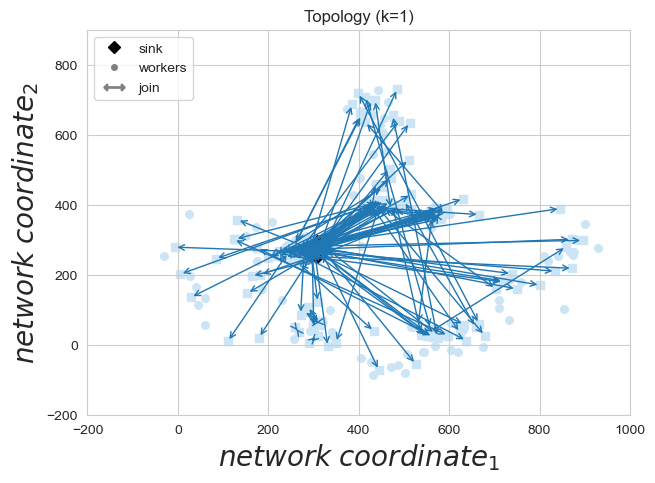

In [9]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))

if clustering:
    ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.3,
                             plot_voronoi=True, plot_centroid=True)
else:
    ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.3,
                             plot_voronoi=False, plot_centroid=False)

for i, j in join_pairs:
    i_ind = i
    j_ind = j
    if join_matrix[i_ind, j_ind] > 0:
        point1 = prim_df.iloc[i_ind][coord_cols].to_numpy()
        point2 = prim_df.iloc[j_ind][coord_cols].to_numpy()
        cluster = prim_df.loc[i_ind, "cluster"]
        # print(i, j, point1, point2)
        arrow = FancyArrowPatch(point1, point2, arrowstyle='<->', mutation_scale=10, color=colors[cluster], linewidth=1)
        ax1.add_patch(arrow)

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

# Create a custom handle for the double-ended arrow line
handles = [coordinator_label, worker_label, join_label]
ax1.legend(handles=handles, loc="upper left", bbox_to_anchor=(0, 1), prop={'size': 10})

plt.savefig(f"plots/atlas/atlas_ct_{device_number}_ncs_grouped_{source_frac}.svg", bbox_inches="tight")
plt.show()

### Create Logical Plan

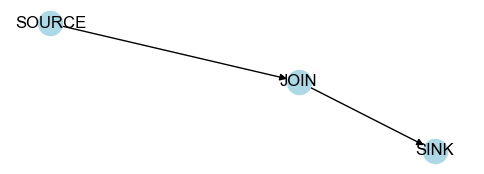

In [10]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 2))

# Create a graph
logical_plan = nx.DiGraph()

# Add nodes with labels as attributes
logical_plan.add_node(1, type=OperatorType.SOURCE)
logical_plan.add_node(2, type=OperatorType.JOIN)
logical_plan.add_node(3, type=OperatorType.SINK)

# Add edges between nodes
logical_plan.add_weighted_edges_from([(1, 2, 1), (2, 3, 1)])

# Draw the graph
pos = nx.nx_agraph.graphviz_layout(logical_plan, prog='neato')
nx.draw(logical_plan, pos, ax=ax1, with_labels=False, arrows=True, node_color='lightblue')

# Extract the labels from node attributes
labels = nx.get_node_attributes(logical_plan, 'type')

# Draw the labels on the graph
nx.draw_networkx_labels(logical_plan, pos, labels)

# Show the plot
plt.show()

## Load Real RTTs

In [11]:
df_rtt_list = []
for i in range(0, 24):
    df_rtt = pd.read_csv(f"datasets/atlas/02072023/rtt_matrix/time-{i}.csv", sep=",")
    df_rtt.columns = range(0, len(df_rtt.columns))
    df_rtt_list.append(df_rtt)
df_rtt = df_rtt_list[0]

In [12]:
len(df_rtt_list)

24

In [13]:
df_rtt.head(10)

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   \
0    0   20   58   37   38   62  394  392  175   31   22   38   37  242  186   
1   20    0   41   33   37   43  337  372  182   20    3    2   19  262  227   
2   58   41    0    9   48   58  536  413  259   44   41   41   52  291  217   
3   37   33    9    0   41   58  506  408  187   18   39   35   48  264  217   
4   38   37   48   41    0   65  406  399  333   26   31   38   57  240  253   
5   62   43   58   58   65    0  498  418  196   45   48   57   63  291  240   
6  394  337  536  506  406  498    0  806  335  468  445  359  365  906  275   
7  392  372  413  408  399  418  806    0  544  391  383  387  363  605  523   
8  175  182  259  187  333  196  335  544    0  185  187  194  182  525   12   
9   31   20   44   18   26   45  468  391  185    0   21   20   30  225  179   

   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   \
0   41  279   26   24   51  702  346   86   62   16  159  263   58  298  186   
1   66  271    8   24   54  321  327   62   34   21  156  272   31  312  226   
2   32  302   49   44   50  361  387   59   62   43  204  310  102  326  261   
3   24  284   44   32   16  301  319   47   61   30  183  277   63  336  200   
4   16  305   41   44   75  695  318  122   55   35  264  272  105  310  203   
5  111  331   49   72   97  488  356   20   49   42  193  310   37  348  272   
6  502  385  354  377  417  755  278  446  489  393  394  626  408  403  643   
7  405  612  381  424  424  832  680  434  389  396  516  137  422  626  523   
8  192  142  203  200  220  464  158  249  196  187   46  435  233  144  375   
9   25  287   27   22   35  341  367   66   38   16  177  274   70  319  178   

   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   \
0   48   21   32   66   41   63   24   53   69   22   21   54   42  298   76   
1   50    5   16   60   23   46   22   33   50    2   25   39   34  279   82   
2   58   55   54   49   54   56   39   34   63   40   32   70   43  321   57   
3   60   34   40   40   21   75   32   29   98   39   25   66   39  288   48   
4   49   53   61   72   58   99   27   22  111   31    1   68   41  297   82   
5   83   48   29   30   34   15   75   72   29   51   63   14   64  321  119   
6  390  375  376  462  387  495  395  418  481  445  385  399  437  406  548   
7  420  396  404  421  406  442  386  402  456  382  395  446  423  635  467   
8  202  193  199  232  227  254  207  227  233  187  227  214  211  131  277   
9   43   21   27   75   31   66   25   13   72   20   19   57   26  296   65   

   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   \
0   15  196   93   95  222   47   20    9   46   23   31   69   69   64   47   
1   27  186  109  105  230   35    2   12   36   39   36   47   67   53   76   
2   56  244   94   85  265    8   43   36   40   52   65   48   55   15   49   
3   57  211  114   67  250    2   34   25   36   50   57   40   46    1   41   
4   16  313  108   74  225   48   37   47   43   12   54   73   80   41   79   
5   69  248  124  156  273   79   47   53   78   93   75   65   40   74  136   
6  430  328  502  540  549  382  362  377  392  370  437  459  396  424  516   
7  365  539  448  468  401  409  389  382  399  416  405  433  446  414  452   
8  193   37  272  300  378  205  195  202  218  224  201  231  228  216  233   
9   43  211  118   90  239   26   52    9   40   36   46   56   81   20   46   

   60   61   62   63   64   65   66   67   68   69   70   71   72   73   74   \
0   87   46   68   60   14   13   38    9  104   41  184  205  100  352   62   
1   70   53   58   21   18   31   35   14   79   20  158  195  121  347   33   
2  115   74   88   47   34   53    9   31   89   66  203  251  114  359   51   
3   92   58   71   43   18   53    1   24   63   52  200  233   73  337   50   
4   74   37  107   37   41   26   40   26   92   57  179  298   96  331   45   

## Comparison of Latencies: RTTs vs Estimates

In [14]:
reduction_fac=0.4
cardinality_dict = {1: source_cardinalities, 2: (join_matrix, join_pairs)}

df_stats = None
nova_placements = {}

In [15]:
capacity_col = base_col
pdf = prim_df.copy()
nova = NovaSolver(pdf, logical_plan, cardinality_dict=cardinality_dict, coord_cols=coord_cols, reduction_fac=reduction_fac,
                  knn_neighbors=2, capacity_col=capacity_col, use_weight=False)
df_nova_it, rep_plan_it, rel_positions_it, placement_it = nova.nova_full()


nova_placements[capacity_col] = df_nova_it, rep_plan_it, rel_positions_it, placement_it
df_stats_it = evaluate_graph(df_nova_it, rep_plan_it, df_rtt=df_rtt, placements=placement_it)
eval_matrix["nova_" + capacity_col] = df_stats_it.copy()

Initializing Nova for 631
Running Nova on capacity_inf
Resolving pinned operators
Resolving join operators
Preparing nodes and edges
Initializing coordinates
Computing relaxed positions for n=568 nodes
Relaxed positions: 568
Replicas for 1:378
Replication count for upstream operators to 1 -> 0
Replicas for 2:189
Distributing load: operator_id=632, opt=[302.32392519065996, 269.00106946313406], upstream_nodes=([np.int64(1), np.int64(2)])
Left=12, right=18, batches=6, batch_factor=0.4, batch_threshold=6.0, required=72, part_req=12 resource_limit=0, neighbor_size=2
Searching knn [302.32392519065996, 269.00106946313406] 630 2 2 0
Distributing finished: operator_id=632 (1, 2) to n=1, opt=[302.32392519065996, 269.00106946313406], upstream_nodes=[497], additional load=0.0
Distributing load: operator_id=633, opt=[304.4412555511187, 270.2579836085143], upstream_nodes=([np.int64(3), np.int64(4)])
Left=66, right=33, batches=8, batch_factor=0.4, batch_threshold=19.0, required=264, part_req=38 resou

In [16]:
for k, vals in nova_placements.items():
    df_nova, rep_plan_nova, rel_positions_nova, placement_nova = vals
    if df_nova[df_nova["free_capacity"] < 0].shape[0] > 0:
        print(f"Overloaded: {k}->{df_nova[df_nova['free_capacity'] < 0].shape[0]}")

In [17]:
df_nova_it.head(10)

x           y    type  unbalanced  weight  real_weight  \
0  308.494393  272.860026    SINK           0       0            0   
1  316.976824  275.994535  SOURCE           0      12           12   
2  282.361038  258.647238  SOURCE           0      18           18   
3  306.501880  265.083892  SOURCE           0      66           66   
4  298.626985  272.848666  SOURCE           0      33           33   
5  290.092099  262.323459  SOURCE           0      31           31   
6  385.222035  687.879640  SOURCE           0      11           11   
7    5.227394  201.997901  SOURCE           0      75           75   
8  444.203377  407.520301  SOURCE           0       3            3   
9  304.542842  271.014081  SOURCE           0      44           44   

   total_capacity  free_capacity  level                          parent  
0         9999999      9998109.0      2                              []  
1         9999999      9999913.0      1          [(497, 12), (0, 44.0)]  
2         9999999      9999999.0      0                     [(497, 18)]  
3         9999999      9999999.0      0                      [(54, 66)]  
4         9999999      9999883.0      1  [(54, 33), (0, 1.0), (0, 1.0)]  
5         9999999      9999999.0      0                     [(505, 31)]  
6         9999999      9999999.0      0                     [(505, 11)]  
7         9999999      9999999.0      0                     [(585, 75)]  
8         9999999      9999999.0      0                      [(585, 3)]  
9         9999999      9999999.0      0                     [(155, 44)]

In [18]:
df_stats_it.head(10)

latency_distribution  latency_distribution_rtt  received_packets
0                     0                         0              1890
1                    23                        55                86
2                    29                        60                 0
3                    10                        73                 0
4                    11                        35               116
5                   368                       412                 0
6                   433                       455                 0
7                   328                       510                 0
8                   270                       322                 0
9                     8                        38                 0

In [19]:
df_stats_filtered = df_stats_it[df_stats_it["latency_distribution"] > 0]
df_stats_filtered.shape[0]

378

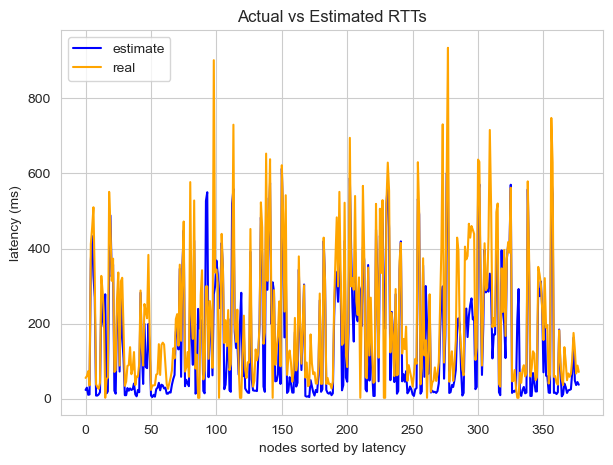

In [20]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5), sharey=False)

sv_rtt = df_stats_filtered["latency_distribution"] #.sort_values()
sv_rtt.plot(ax=ax1, use_index=False, label="estimate", color="blue")

sv_rtt = df_stats_filtered["latency_distribution_rtt"] #.sort_values()
sv_rtt.plot(ax=ax1, use_index=False, label="real", color="orange")

ax1.set_title('Actual vs Estimated RTTs')
ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')
ax1.legend(loc="upper left", prop={'size': 10}, ncol=1)

plt.show()

## Changing Topology

In [21]:
# for the plots and vanilla nova
df = prim_df.copy()
df["x"] = coord_list[0]["x"]
df["y"] = coord_list[0]["y"]
df["latency"] = coord_list[0]["latency"]

df_sum = df
df_sum["x"] = coord_list[0]["x"]
df_sum["y"] = coord_list[0]["y"]
df_sum['latency'] = coord_list[0]["latency"]

placements_nova = []
evaluations_full = []
evaluations_init = []

for i, coords_df in enumerate(coord_list):
    print("---------------Starting", i)
    if i > 0:
        df_sum["x"] += coords_df["x"]
        df_sum["y"] += coords_df["y"]
        df = df_sum.copy()
        df["x"] = df["x"] / i
        df["y"] = df["y"] / i
        df['latency'] = list(zip(df.x, df.y))
        df['latency'] = df['latency'].apply(lambda x: np.linalg.norm(x - df.loc[0, ["x", "y"]].to_numpy()))

    placements_capacities = {}
    evaluations_capacities = {}
    for capacity_col in eval_columns:
        # create a new placement for every df
        nova = NovaSolver(df, logical_plan, cardinality_dict=cardinality_dict, coord_cols=coord_cols, reduction_fac=reduction_fac,
                          knn_radius=155, k_resources=prim_df[capacity_col].median()//2, capacity_col=capacity_col, use_weight=False)
        placements_capacities[capacity_col] = nova.nova_full()
        df_nova_it, rep_plan_it, rel_positions_it, placement_it = placements_capacities[capacity_col]
        df_stats_it = evaluate_graph(df_nova_it, rep_plan_it, df_rtt=df_rtt_list[i], placements=placement_it)
        evaluations_capacities[capacity_col] = df_stats_it[df_stats_it["latency_distribution"] > 0]
    placements_nova.append(placements_capacities)
    evaluations_full.append(evaluations_capacities)

    evaluations_capacities_init = {}
    for capacity_col in eval_columns:
        # get the initial placement and evaluate it with current rtts
        df_nova_it, rep_plan_it, rel_positions_it, placement_it = placements_nova[0][capacity_col]
        df_stats_it = evaluate_graph(df_nova_it, rep_plan_it, df_rtt=df_rtt_list[i], placements=placement_it)
        evaluations_capacities_init[capacity_col] = df_stats_it[df_stats_it["latency_distribution"] > 0]
    evaluations_init.append(evaluations_capacities_init)

---------------Starting 0
Initializing Nova for 631
Running Nova on capacity_1
Resolving pinned operators
Resolving join operators
Preparing nodes and edges
Initializing coordinates
Computing relaxed positions for n=568 nodes
Relaxed positions: 568
Replicas for 1:378
Replication count for upstream operators to 1 -> 0
Replicas for 2:189
Distributing load: operator_id=632, opt=[-62.11854113418362, 40.46159009682405], upstream_nodes=([np.int64(1), np.int64(2)])
Left=12, right=18, batches=6, batch_factor=0.4, batch_threshold=6.0, required=72, part_req=12 resource_limit=16.0, neighbor_size=None
Searching knn [-62.11854113418362, 40.46159009682405] 523 None 2 0
155 0 523
Distributing finished: operator_id=632 (1, 2) to n=1, opt=[-62.11854113418362, 40.46159009682405], upstream_nodes=[522], additional load=0.0
Distributing load: operator_id=633, opt=[-89.71860330798718, 22.345247493697347], upstream_nodes=([np.int64(3), np.int64(4)])
Left=66, right=33, batches=8, batch_factor=0.4, batch_thres

## Evaluation

#### Latency

In [22]:
print(len(placements_nova), len(evaluations_full), len(evaluations_init))
print(evaluations_full[0].keys())
print(evaluations_init[0].keys())

24 24 24
dict_keys(['capacity_1', 'capacity_5'])
dict_keys(['capacity_1', 'capacity_5'])


Means re: {'0': np.float64(234.61), '1': np.float64(243.69), '2': np.float64(247.85), '3': np.float64(249.1), '4': np.float64(237.89), '5': np.float64(239.58), '6': np.float64(242.92), '7': np.float64(232.74), '8': np.float64(228.67), '9': np.float64(224.58), '10': np.float64(224.87), '11': np.float64(231.4), '12': np.float64(228.66), '13': np.float64(225.92), '14': np.float64(230.06), '15': np.float64(228.0), '16': np.float64(228.05), '17': np.float64(227.94), '18': np.float64(229.76), '19': np.float64(229.58), '20': np.float64(228.6), '21': np.float64(227.16), '22': np.float64(227.09), '23': np.float64(227.15)}
Quantiles re: {'0': np.float64(503.0), '1': np.float64(568.2), '2': np.float64(570.2), '3': np.float64(564.8), '4': np.float64(537.5), '5': np.float64(517.4), '6': np.float64(521.0), '7': np.float64(510.5), '8': np.float64(503.2), '9': np.float64(476.3), '10': np.float64(465.5), '11': np.float64(486.1), '12': np.float64(479.3), '13': np.float64(476.0), '14': np.float64(477.3),

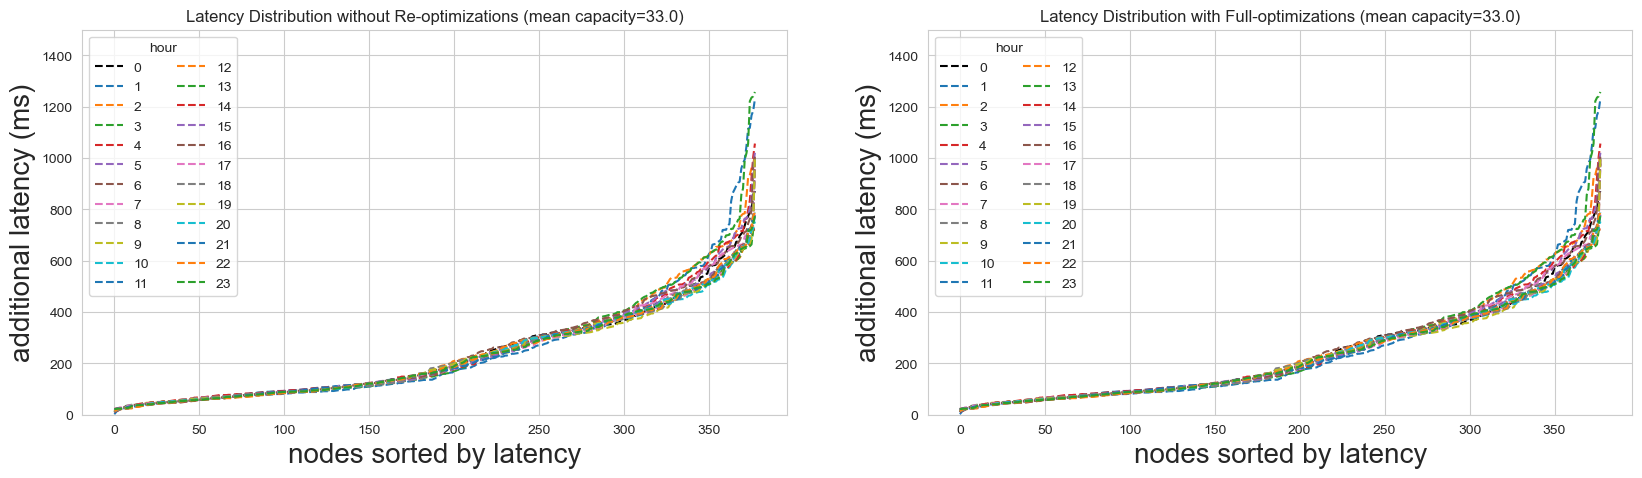

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=False)
eval_dict_no = {}

quant_dict_re = {}
mean_dict_re = {}

prim_eval = coord_dict[t_label]["latency"]
nodes_take = 50
changed_nodes = {}

sl_plot = "capacity_1"

for i in range(len(placements_nova)):
    l = str(i)
    eval_dict_no[i] = {}
    for sl in eval_columns:
        eval_df = evaluations_init[i][sl]
        sv = eval_df.sort_index()["latency_distribution_rtt"]
        sv = sv.sort_values()
    
        res = {"90": round(sv.quantile(0.9), 2), 
               "80": round(sv.quantile(0.8), 2), 
               "70": round(sv.quantile(0.7), 2),
               "mean": round(sv.mean(), 2)}
        eval_dict_no[i][sl] = res
        
    eval_df = evaluations_full[i][sl_plot]
    sv = eval_df.sort_index()["latency_distribution_rtt"]
    sv = sv.sort_values()

    if i > 0:
        changed_nodes[i] = list(sv.index[-nodes_take:])  # Get the last 100 indexes

    if i == 0:
        sv.plot(ax=ax1, use_index=False, label=l, linestyle="--", color="black")
    else:
        sv.plot(ax=ax1, use_index=False, label=l, linestyle="--")

    sv1 = eval_df.sort_index()["latency_distribution_rtt"]
    sv = sv1  # - sv2
    sv = sv.sort_values()
    quant_dict_re[l] = round(sv.quantile(0.9), 2)
    mean_dict_re[l] = round(sv.mean(), 2)

    if i > 0:
        changed_nodes[i] = list(sv.index[-nodes_take:])  # Get the last 100 indexes

    if i == 0:
        sv.plot(ax=ax2, use_index=False, label=l, linestyle="--", color="black")
    else:
        sv.plot(ax=ax2, use_index=False, label=l, linestyle="--")

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('additional latency (ms)')
ax1.legend(loc="upper left", prop={'size': 10}, ncol=2, title="hour")

ax2.set_xlabel('nodes sorted by latency')
ax2.set_ylabel('additional latency (ms)')
ax2.legend(loc="upper left", prop={'size': 10}, ncol=2, title="hour")
# Display a figure.
# plt.ylim([0, 100])

ax1.set_ylim([0, 1500])
ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)
ax2.yaxis.label.set_size(20)
ax2.xaxis.label.set_size(20)
ylim_orig = ax1.get_ylim()
ax2.set_ylim(ylim_orig)

# plt.savefig("plots/sim_1000/eval_latency.svg")

print("Means re:", mean_dict_re)
print("Quantiles re:", quant_dict_re)

ax1.set_title(f'Latency Distribution without Re-optimizations (mean capacity={medians[sl_plot]})')
ax2.set_title(f'Latency Distribution with Full-optimizations (mean capacity={medians[sl_plot]})')
plt.show()

In [24]:
eval_dict_no

{0: {'capacity_1': {'90': np.float64(503.0),
   '80': np.float64(370.0),
   '70': np.float64(321.0),
   'mean': np.float64(234.61)},
  'capacity_5': {'90': np.float64(503.0),
   '80': np.float64(367.6),
   '70': np.float64(320.0),
   'mean': np.float64(233.52)}},
 1: {'capacity_1': {'90': np.float64(483.9),
   '80': np.float64(371.6),
   '70': np.float64(322.0),
   'mean': np.float64(233.25)},
  'capacity_5': {'90': np.float64(506.3),
   '80': np.float64(370.2),
   '70': np.float64(321.8),
   'mean': np.float64(234.88)}},
 2: {'capacity_1': {'90': np.float64(488.4),
   '80': np.float64(371.0),
   '70': np.float64(321.0),
   'mean': np.float64(234.37)},
  'capacity_5': {'90': np.float64(507.0),
   '80': np.float64(375.8),
   '70': np.float64(319.8),
   'mean': np.float64(235.18)}},
 3: {'capacity_1': {'90': np.float64(511.8),
   '80': np.float64(388.2),
   '70': np.float64(321.9),
   'mean': np.float64(237.7)},
  'capacity_5': {'90': np.float64(521.9),
   '80': np.float64(376.2),
   '70

In [25]:
markers = {
    "90": {eval_columns[0]: "<", eval_columns[1]: ">"},
    "mean": {eval_columns[0]: "^", eval_columns[1]: "v"}
}

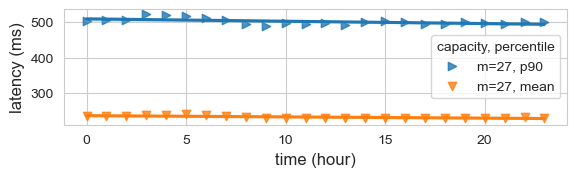

In [33]:
# Create a figure and axes for the scatter plot
fig, ax = plt.subplots(figsize=(6.5, 1.5))

# Assuming quants_no and quants_re are dictionaries
for quant in ["90", "mean"]:
    for capacity in eval_columns:
        if capacity != eval_columns[-1]:
            continue

        vals_w1 = []
        for i in eval_dict_no.keys():
            valw1 = eval_dict_no[i][capacity][quant]
            vals_w1.append(valw1)

        quant_label = quant
        if quant == "90":
            quant_label = "p90"
        sns.regplot(x=[i for i in range(len(vals_w1))], y=vals_w1, scatter=True, label=f"m={int(medians[capacity])}, {quant_label}", marker=markers[quant][capacity])

# Set the axis labels and title
plt.xlabel('time (hour)', fontsize=12)
plt.ylabel('latency (ms)', fontsize=12)

# Set the legend
plt.legend(title="capacity, percentile", loc="center right")

# Show the plot
plt.savefig("plots/evolution_latency_atlas.svg", bbox_inches='tight')
plt.show()